## Problema 1: Implementación del Método Simplex Estánda

\begin{aligned}
\text{Maximizar} \quad & Z = 3x_1 + 2x_2 + 5x_3 \\
\text{sujeto a} \quad 
& x_1 + x_2 + x_3 \le 100 \\
& 2x_1 + x_2 + x_3 \le 150 \\
& x_1 + 4x_2 + 2x_3 \le 80 \\
& x_1,\, x_2,\, x_3 \ge 0
\end{aligned}

###  Problema de forma estandar con variables de holgura:

$$ x_1 + x_2 + x_3 + s_1 = 100  $$
$$ 2x_1 + x_2 + x_3 + s_2 = 150  $$
$$ x_1 + 4x_2 + 2x_3 + s_3 = 80 $$
$$ x_1,\, x_2,\, x_3, s_1, s_2, s_3 \ge 0$$


### Implementacion del metodo simplex

In [ ]:
import numpy as np
import pandas as pd
from pyomo.environ import *

# Funcion objetivo Z = 3x1 + 2x2 + 5x3
A = np.array([3, 2, 5])   

# Coeficientes de las restricciones
B = np.array([[1, 1, 1], [2, 1, 1], [1, 4, 2]])

# Valores del lado derecho de las restricciones
C = np.array([100, 150, 80])

# Transformamos el problema inicial a forma estandar 
def transformacion_estandar(A, B, C):
    filas, columnas = B.shape
    variables_holgura = np.eye(filas)                     
    tabla_simplex = np.hstack([B, variables_holgura])    
    coeficientes = np.concatenate([A, np.zeros(filas)])  
    variables = [f"x{i+1}" for i in range(columnas)] + [f"s{i+1}" for i in range(filas)]
    va = [f"x{i+1}" for i in range(columnas)]
    return tabla_simplex, C, coeficientes, variables,  va

# Imprimimos la tabla inicial simplex
tabla, C, coeficientes, nombres_variables, va = transformacion_estandar(A, B, C)
tabla_simplex = pd.DataFrame(tabla, columns = nombres_variables)
tabla_simplex["Solucion"] = C
tabla_simplex.index = [f"s{i+1}" for i in range(1, len(C)+1)]
fila_z = pd.DataFrame([np.concatenate([-coeficientes, [0]])], columns = nombres_variables + ["Solucion"], index=["Z"])
tabla_simplex = pd.concat([fila_z, tabla_simplex])
print("Tabla simplex inicial")
print(tabla_simplex)
print("")

# Variables basicas y sus valores
variables_basicas = [f"s{i+1}" for i in range(len(C))]
valores_basicos = C.copy()

# Variables no basicas y sus valores
variables_no_basicas = [f"x{i+1}" for i in range(len(A))]
valores_no_basicos = np.zeros(len(A))

# Imprimimos la solucion basica factible inicial
print("Solucion basica factible inicial")
for v, val in zip(variables_no_basicas, valores_no_basicos):
    print(f"{v} = {val:.2f}")
for v, val in zip(variables_basicas, valores_basicos):
    print(f"{v} = {val:.2f}")
print(f"Z = 0")

def simplex(tabla_simplex, n, variables_entrada):
   

    iteracion = 1
    min_col = tabla_simplex.loc["Z", variables_entrada].idxmin()

    # Mientras haya coeficientes negativos en la fila Z → seguimos iterando
    while tabla_simplex.loc["Z", min_col] < 0:
        print(f"\n Iteración {iteracion}: entra {min_col}")

        # --- Paso 1: determinar variable saliente ---
        ratios = []
        for i in range(1, len(tabla_simplex)):
            aij = tabla_simplex.iloc[i][min_col]
            bi = tabla_simplex.iloc[i]["Solucion"]
            if aij > 0:
                ratios.append(bi / aij)
            else:
                ratios.append(np.inf)
        fila_salida_idx = np.argmin(ratios) + 1  # +1 por la fila Z
        fila_salida = tabla_simplex.index[fila_salida_idx]
        print(f"Variable saliente: {fila_salida}")

        # --- Paso 2: pivotear ---
        pivote = tabla_simplex.loc[fila_salida, min_col]
        tabla_simplex.loc[fila_salida] = tabla_simplex.loc[fila_salida] / pivote

        # Eliminar la variable entrante de las demás filas
        for i in tabla_simplex.index:
            if i != fila_salida:
                factor = tabla_simplex.loc[i, min_col]
                tabla_simplex.loc[i] = tabla_simplex.loc[i] - factor * tabla_simplex.loc[fila_salida]

        # Actualizar nombre de fila básica
        tabla_simplex.rename(index={fila_salida: min_col}, inplace=True)

        print(tabla_simplex)

        # --- Paso 3: verificar nueva variable entrante ---
        min_col = tabla_simplex.loc["Z", variables_entrada].idxmin()
        iteracion += 1

    # --- Paso 4: imprimir solución ---
    print(" Solución óptima encontrada:")
    solucion = [0] * n
    for var in variables_entrada:
        if var in tabla_simplex.index:
            solucion[int(var[1:]) - 1] = tabla_simplex.loc[var, "Solucion"]

    Z_opt = tabla_simplex.loc["Z", "Solucion"]
    for i, val in enumerate(solucion, start=1):
        print(f"x{i} = {val:.2f}")
    print(f"Z = {Z_opt:.2f}")

    return(iteracion)

    
simplex(tabla_simplex, 3, va )



Tabla simplex inicial
     x1   x2   x3   s1   s2   s3  Solucion
Z  -3.0 -2.0 -5.0 -0.0 -0.0 -0.0       0.0
s2  1.0  1.0  1.0  1.0  0.0  0.0     100.0
s3  2.0  1.0  1.0  0.0  1.0  0.0     150.0
s4  1.0  4.0  2.0  0.0  0.0  1.0      80.0

Solucion basica factible inicial
x1 = 0.00
x2 = 0.00
x3 = 0.00
s1 = 100.00
s2 = 150.00
s3 = 80.00
Z = 0

 Iteración 1: entra x3
Variable saliente: s4
     x1   x2   x3   s1   s2   s3  Solucion
Z  -0.5  8.0  0.0  0.0  0.0  2.5     200.0
s2  0.5 -1.0  0.0  1.0  0.0 -0.5      60.0
s3  1.5 -1.0  0.0  0.0  1.0 -0.5     110.0
x3  0.5  2.0  1.0  0.0  0.0  0.5      40.0

 Iteración 2: entra x1
Variable saliente: s3
     x1        x2   x3   s1        s2        s3    Solucion
Z   0.0  7.666667  0.0  0.0  0.333333  2.333333  236.666667
s2  0.0 -0.666667  0.0  1.0 -0.333333 -0.333333   23.333333
x1  1.0 -0.666667  0.0  0.0  0.666667 -0.333333   73.333333
x3  0.0  2.333333  1.0  0.0 -0.333333  0.666667    3.333333
 Solución óptima encontrada:
x1 = 73.33
x2 = 0.00
x

### Problema 2: Implementación del Método Simplex Dual Phase

\begin{aligned}
\text{Maximizar} \quad & Z = 5x_1 - 4x_2 + 3x_3 \\
\text{sujeto a} \quad 
& 2x_1 + x_2 - x_3 = 10 \\
& 2x_1 - 3x_2 + 2x_3 \ge 5 \\
& x_1 + x_2 + x_3 \le 15 \\
& x_1,\, x_2,\, x_3 \ge 0
\end{aligned}

$$ 2x_1 + x_2 - x_3 + r_1 = 10 $$
$$ 2x_1 - 3x_2 + 2x_3 +s_1 + r_2= 5 $$
$$ x_1 + x_2 + x_3 s_2 = 15 $$
$$ x_1,\, x_2,\, x_3, s_1,s_2, r_1,r_2\ge 0 $$


In [22]:
# Funcion objetivo Z = 3x1 + 2x2 + 5x3
A = np.array([5, -4, 3])   

# Coeficientes de las restricciones
B = np.array([[2, 1, -1], [1, -3, 2], [1, 1, 1]])

# Valores del lado derecho de las restricciones
C = np.array([10, 5, 15])

# Transformamos el problema inicial a forma estandar 
def transformacion_dual(A, B, C):
    filas, columnas = B.shape
    variables_holgura = [[0,0,1,0],[-1,0,0,1],[0,1,0,0]]                    
    tabla_simplex = np.hstack([B, variables_holgura])    
    coeficientes = [0,0,0,0,0,-1,-1]
    variables = [f"x{i+1}" for i in range(columnas)] + [f"s{i+1}" for i in range(2)] + [f"r{j+1}" for j in range(2)] 
    return tabla_simplex, C, coeficientes, variables

# Imprimimos la tabla inicial simplex
tabla, C, coeficientes, nombres_variables = transformacion_dual(A, B, C)
tabla_simplex = pd.DataFrame(tabla, columns = nombres_variables)
tabla_simplex["Solucion"] = C
tabla_simplex.index = ["r1","r2", "s2"]
fila_z = pd.DataFrame([np.concatenate([coeficientes, [0]])], columns = nombres_variables + ["Solucion"], index=["Z"])
tabla_simplex = pd.concat([fila_z, tabla_simplex])
print("Tabla simplex inicial")
print(tabla_simplex)
print("")

# Variables basicas y sus valores
variables_basicas = [f"s{i+1}" for i in range(len(C))]
valores_basicos = C.copy()

# Variables no basicas y sus valores
variables_no_basicas = [f"x{i+2}" for i in range(len(A)-1)]
valores_no_basicos = np.zeros(len(A))

# Imprimimos la solucion basica factible inicial
print("Solucion basica factible inicial")
for v, val in zip(variables_no_basicas, valores_no_basicos):
    print(f"{v} = {val:.2f}")
for v, val in zip(variables_basicas, valores_basicos):
    print(f"{v} = {val:.2f}")
print(f"Z = 0")

print(tabla_simplex)
def simplex_dual (tabla_simplex, n):
  
    tabla_simplex.loc["Z"] =- (tabla_simplex.iloc[1]+tabla_simplex.iloc[2])
    print(tabla_simplex)
    min_value = tabla_simplex.loc["Z", [ "x1", "x2","x3"]].idxmin()
    mini_usados = []
    while  (tabla_simplex.loc["Z"][min_value]<0 ):
    
        x = 1
        minimo = tabla_simplex.iloc[1]["Solucion"]/tabla_simplex.iloc[1][min_value]
        iminimo = 1 
     
                
        while x < 4:
            min = tabla_simplex.iloc[x]["Solucion"]/tabla_simplex.iloc[x][min_value]
            if (minimo < 0 ):
                minimo =  min 
                iminimo = x
            if ((min < minimo) & (min >= 0) ):
                minimo =  min 
                iminimo = x
            
            x+=1
        mini_usados.append(iminimo)
        print(minimo)

        nueva_fial = tabla_simplex.iloc[iminimo]/tabla_simplex.iloc[iminimo][min_value]
        tabla_simplex.index.values[iminimo] = min_value
        tabla_simplex.iloc[iminimo] = nueva_fial


        d =0
        for index, row in tabla_simplex.iterrows():
            if (min_value== index):
                d +=1
                continue

            cc = nueva_fial*row[min_value]
            tabla_simplex.iloc[d] = tabla_simplex.iloc[d]-cc
            d +=1
            
        print(tabla_simplex)
        min_value = tabla_simplex.loc["Z", [ "x1", "x2","x3"]].idxmin()

    print("---Solucion---")
    solcion = [0]*((n))
    for index, row in tabla_simplex.iterrows():
        if ("s" in index):
            continue
        if ("Z" in index):
            solcion.append(str(round(row["Solucion"],2)))
            continue
        solcion[int(index[1])-1] = str(round(row["Solucion"],2))

    indexx = 1
    for i in solcion: 
        if (indexx == len(solcion)):
            print("z", "=",i)
            continue
        print("x"+str(indexx), "=",i)
        indexx+=1
    return (tabla_simplex)

# fase dos
def simplex_dual2 (tabla_simplex, n):
    
    B2 = np.eye(3)  
    c_B = [5,3,0]
    A = tabla_simplex.iloc[1:4].drop(columns=['Solucion']).values.tolist()
    b =  tabla_simplex.iloc[1:4]["Solucion"]
    c = [5, -4, 3, 0,0]
    B_inv = np.linalg.inv(B2)       
    z = c_B @ B_inv @ A            
    r = c - z    
    Z = c_B @ B_inv @ b 
    r = np.append(r, Z)
    tabla_simplex.loc["Z"] = r
    min_value = tabla_simplex.loc["Z", [ "x1", "x2","x3","s1", "s2"]].idxmin()
    mini_usados = []
    while  (tabla_simplex.loc["Z"][min_value]<0 ):
    
        x = 1
        minimo = tabla_simplex.iloc[1]["Solucion"]/tabla_simplex.iloc[1][min_value]
        iminimo = 1 
     
                
        while x < 4:
            min = tabla_simplex.iloc[x]["Solucion"]/tabla_simplex.iloc[x][min_value]
            if (minimo < 0 ):
                minimo =  min 
                iminimo = x
            if ((min < minimo) & (min >0) ):
                minimo =  min 
                iminimo = x
            
            x+=1
        mini_usados.append(iminimo)
        print(minimo)

        nueva_fial = tabla_simplex.iloc[iminimo]/tabla_simplex.iloc[iminimo][min_value]
        tabla_simplex.index.values[iminimo] = min_value
        tabla_simplex.iloc[iminimo] = nueva_fial


        d =0
        for index, row in tabla_simplex.iterrows():
            if (min_value== index):
                d +=1
                continue

            cc = nueva_fial*row[min_value]
            tabla_simplex.iloc[d] = tabla_simplex.iloc[d]-cc
            d +=1
            
        print(tabla_simplex)
        min_value = tabla_simplex.loc["Z", [ "x1", "x2","x3","s1", "s2"]].idxmin()

    print("---Solucion---")
    solcion = [0]*((n))
    for index, row in tabla_simplex.iterrows():
        if ("s" in index):
            continue
        if ("Z" in index):
            solcion.append(str(round(row["Solucion"],2)))
            continue
        solcion[int(index[1])-1] = str(round(row["Solucion"],2))

    indexx = 1
    for i in solcion: 
        if (indexx == len(solcion)):
            print("z", "=",i)
            continue
        print("x"+str(indexx), "=",i)
        indexx+=1
   

tabala = simplex_dual(tabla_simplex, 3)
tabala= tabala.drop(columns=['r1', 'r2'])
tabala.loc["Z"] = np.concatenate([-A, [0,0,0]]) 

simplex_dual2(tabala, 3)

Tabla simplex inicial
    x1  x2  x3  s1  s2  r1  r2  Solucion
Z    0   0   0   0   0  -1  -1         0
r1   2   1  -1   0   0   1   0        10
r2   1  -3   2  -1   0   0   1         5
s2   1   1   1   0   1   0   0        15

Solucion basica factible inicial
x2 = 0.00
x3 = 0.00
s1 = 10.00
s2 = 5.00
s3 = 15.00
Z = 0
    x1  x2  x3  s1  s2  r1  r2  Solucion
Z    0   0   0   0   0  -1  -1         0
r1   2   1  -1   0   0   1   0        10
r2   1  -3   2  -1   0   0   1         5
s2   1   1   1   0   1   0   0        15
    x1  x2  x3  s1  s2  r1  r2  Solucion
Z   -3   2  -1   1   0  -1  -1       -15
r1   2   1  -1   0   0   1   0        10
r2   1  -3   2  -1   0   0   1         5
s2   1   1   1   0   1   0   0        15
5.0
    x1   x2   x3  s1  s2   r1  r2  Solucion
Z    0  3.5 -2.5   1   0  0.5  -1         0
x1   1  0.5 -0.5   0   0  0.5   0         5
r2   0 -3.5  2.5  -1   0 -0.5   1         0
s2   0  0.5  1.5   0   1 -0.5   0        10
0.0
    x1   x2   x3   s1  s2   r1   r2  Soluci

C:\Users\msant\AppData\Local\Temp\ipykernel_38244\3436849095.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabla_simplex.iloc[iminimo] = nueva_fial
C:\Users\msant\AppData\Local\Temp\ipykernel_38244\3436849095.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabla_simplex.iloc[iminimo] = nueva_fial
C:\Users\msant\AppData\Local\Temp\ipykernel_38244\3436849095.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabla_simplex.iloc[iminimo] = nueva_fial
C:\

### Punto tres: Comparación de Rendimiento con GLPK/Pyomo

In [29]:
import numpy as np
import time
from pyomo.environ import *

# --- Datos del problema ---
c = [5, 8, 3, 7, 6, 9, 4, 10, 2, 11]
A = [
    [1,2,1,1,0,0,3,1,2,1],
    [2,1,0,2,1,1,0,3,1,2],
    [1,1,2,0,2,1,1,0,3,1],
    [0,2,1,1,1,0,2,1,1,1],
    [2,0,1,1,1,2,1,1,0,2],
    [1,1,1,1,1,1,1,1,1,1],
    [0,1,2,1,0,1,2,1,1,0],
    [1,0,1,2,1,0,1,2,1,1]
]
b = [50, 60, 55, 40, 45, 70, 65, 50]

# --- Modelo Pyomo ---
model = ConcreteModel()
n = len(c)
m = len(b)

model.x = Var(range(n), domain=NonNegativeReals)
model.obj = Objective(expr=sum(c[i]*model.x[i] for i in range(n)), sense=maximize)

model.constraints = ConstraintList()
for j in range(m):
    model.constraints.add(sum(A[j][i]*model.x[i] for i in range(n)) <= b[j])

# --- Resolver con GLPK ---
solver = SolverFactory('glpk')

start1 = time.time()
result = solver.solve(model, tee=True)
end1 = time.time()

# --- Mostrar resultados ---
print("Estado:", result.solver.status)
print("Terminación:", result.solver.termination_condition)
print(f"Valor óptimo Z = {model.obj():.2f}\n")

print("Variables óptimas:")
for i in range(n):
    print(f"x{i+1} = {model.x[i]():.4f}")

B = np.array(A)
A =  np.array(c)
C  =  np.array(b)

def transformacion_estandar(A, B, C):
    filas, columnas = B.shape
    variables_holgura = np.eye(filas)                     
    tabla_simplex = np.hstack([B, variables_holgura])    
    coeficientes = np.concatenate([A, np.zeros(filas)])  
    variables = [f"x{i+1}" for i in range(columnas)] + [f"s{i+1}" for i in range(filas)]
    va = [f"x{i+1}" for i in range(columnas)]
    return tabla_simplex, C, coeficientes, variables, va

start2 = time.time()
# Imprimimos la tabla inicial simplex
tabla, C, coeficientes, nombres_variables, va = transformacion_estandar(A, B, C)
tabla_simplex = pd.DataFrame(tabla, columns = nombres_variables)
tabla_simplex["Solucion"] = C
tabla_simplex.index = [f"s{i+1}" for i in range(1, len(C)+1)]
fila_z = pd.DataFrame([np.concatenate([-coeficientes, [0]])], columns = nombres_variables + ["Solucion"], index=["Z"])
tabla_simplex = pd.concat([fila_z, tabla_simplex])
print("Tabla simplex inicial")
print(tabla_simplex)
print("")

# Variables basicas y sus valores
variables_basicas = [f"s{i+1}" for i in range(len(C))]
valores_basicos = C.copy()

# Variables no basicas y sus valores
variables_no_basicas = [f"x{i+1}" for i in range(len(A))]
valores_no_basicos = np.zeros(len(A))

# Imprimimos la solucion basica factible inicial
print("Solucion basica factible inicial")
for v, val in zip(variables_no_basicas, valores_no_basicos):
    print(f"{v} = {val:.2f}")
for v, val in zip(variables_basicas, valores_basicos):
    print(f"{v} = {val:.2f}")
print(f"Z = 0")

iteracionesSimplex = simplex(tabla_simplex, 10, va)
end2 = time.time()

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\msant\AppData\Local\Temp\tmpmuryz65l.glpk.raw --wglp C:\Users\msant\AppData\Local\Temp\tmpj6d94cbj.glpk.glp
 --cpxlp C:\Users\msant\AppData\Local\Temp\tmpg1dvnaku.pyomo.lp
Reading problem data from 'C:\Users\msant\AppData\Local\Temp\tmpg1dvnaku.pyomo.lp'...
8 rows, 10 columns, 65 non-zeros
118 lines were read
Writing problem data to 'C:\Users\msant\AppData\Local\Temp\tmpj6d94cbj.glpk.glp'...
104 lines were written
GLPK Simplex Optimizer 5.0
8 rows, 10 columns, 65 non-zeros
Preprocessing...
8 rows, 10 columns, 65 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  3.000e+00  ratio =  3.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 8
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (10)
*     4: obj =   3.756250000e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (35431 bytes)
Writing bas

In [31]:
print("--Solver--")
print(f"Tiempo de resolución: {end1-start1:.4f} segundos")
print("Iteraciones: 4" )

print("--Nuestra solucion--")
print(f"Tiempo de resolución: {end2-start2:.4f} segundos")
print("Iteraciones: 4"  )

--Solver--
Tiempo de resolución: 0.0835 segundos
Iteraciones: 4
--Nuestra solucion--
Tiempo de resolución: 0.1836 segundos
Iteraciones: 4


Como nos podemos dar cuenta la cantidad de iteraciones que se tiene es exactamente la misma lo que cambia bastante es el tiempo en este caso nuestra solucion tarda 0.1 segundos más que la del solver. Por otro lado ambos soluciones son igul de optimas entonces la precision es muy similar.

Por otro lado GLPK utiliza estrategias avanzadas de pivoteo como Devex o Steepest-edge que reducen el número de iteraciones. Tambien mantiene y actualiza la factorización LU de la base en lugar de recalcularla completamente, lo que ahorra tiempo. Emplea estructuras de datos dispersas y ordenamientos eficientes para minimizar el uso de memoria y operaciones innecesarias. Además, incluye heurísticas de arranque (crash start), mecanismos anti-ciclaje y la posibilidad de alternar entre métodos primal, dual e interior-point, eligiendo automáticamente la estrategia más eficiente según la estructura del problema.


In [39]:
import json
x = 0
ruta = "lp_instances.json"


# Cargar el archivo JSON
with open(ruta, "r") as f:
    data = json.load(f)
ass = data["A"]

bs= data["b"]
cs= data["c"]
tiemposS = []
tiemposN = []
numeroN = []
while x < len(ass):
    c = cs[x]
    A = ass[x]
    b = bs[x]
    model = ConcreteModel()
    n = len(c)
    m = len(b)

    model.x = Var(range(n), domain=NonNegativeReals)
    model.obj = Objective(expr=sum(c[i]*model.x[i] for i in range(n)), sense=maximize)

    model.constraints = ConstraintList()
    for j in range(m):
        model.constraints.add(sum(A[j][i]*model.x[i] for i in range(n)) <= b[j])

    # --- Resolver con GLPK ---
    solver = SolverFactory('glpk')

    start1 = time.time()
    result = solver.solve(model, tee=True)
    end1 = time.time()

    # --- Mostrar resultados ---
    print("Estado:", result.solver.status)
    print("Terminación:", result.solver.termination_condition)
    print(f"Valor óptimo Z = {model.obj():.2f}\n")

    print("Variables óptimas:")
    for i in range(n):
        print(f"x{i+1} = {model.x[i]():.4f}")

    B = np.array(A)
    A =  np.array(c)
    C  =  np.array(b)

    def transformacion_estandar(A, B, C):
        filas, columnas = B.shape
        variables_holgura = np.eye(filas)                     
        tabla_simplex = np.hstack([B, variables_holgura])    
        coeficientes = np.concatenate([A, np.zeros(filas)])  
        variables = [f"x{i+1}" for i in range(columnas)] + [f"s{i+1}" for i in range(filas)]
        va = [f"x{i+1}" for i in range(columnas)]
        return tabla_simplex, C, coeficientes, variables, va

    start2 = time.time()
    # Imprimimos la tabla inicial simplex
    tabla, C, coeficientes, nombres_variables, va = transformacion_estandar(A, B, C)
    tabla_simplex = pd.DataFrame(tabla, columns = nombres_variables)
    tabla_simplex["Solucion"] = C
    tabla_simplex.index = [f"s{i+1}" for i in range(1, len(C)+1)]
    fila_z = pd.DataFrame([np.concatenate([-coeficientes, [0]])], columns = nombres_variables + ["Solucion"], index=["Z"])
    tabla_simplex = pd.concat([fila_z, tabla_simplex])
    print("Tabla simplex inicial")
    print(tabla_simplex)
    print("")

    # Variables basicas y sus valores
    variables_basicas = [f"s{i+1}" for i in range(len(C))]
    valores_basicos = C.copy()

    # Variables no basicas y sus valores
    variables_no_basicas = [f"x{i+1}" for i in range(len(A))]
    valores_no_basicos = np.zeros(len(A))

    # Imprimimos la solucion basica factible inicial
    print("Solucion basica factible inicial")
    for v, val in zip(variables_no_basicas, valores_no_basicos):
        print(f"{v} = {val:.2f}")
    for v, val in zip(variables_basicas, valores_basicos):
        print(f"{v} = {val:.2f}")
    print(f"Z = 0")

    iteracionesSimplex = simplex(tabla_simplex, len(A), va)
    end2 = time.time()
    tiemposS.append(end1-start1)
    tiemposN.append(end2-start2)
    numeroN.append(len(A))
    x += 1



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\msant\AppData\Local\Temp\tmp_pgztwqo.glpk.raw --wglp C:\Users\msant\AppData\Local\Temp\tmpen6b9yqv.glpk.glp
 --cpxlp C:\Users\msant\AppData\Local\Temp\tmprh300aqm.pyomo.lp
Reading problem data from 'C:\Users\msant\AppData\Local\Temp\tmprh300aqm.pyomo.lp'...
2 rows, 5 columns, 10 non-zeros
35 lines were read
Writing problem data to 'C:\Users\msant\AppData\Local\Temp\tmpen6b9yqv.glpk.glp'...
27 lines were written
GLPK Simplex Optimizer 5.0
2 rows, 5 columns, 10 non-zeros
Preprocessing...
2 rows, 5 columns, 10 non-zeros
Scaling...
 A: min|aij| =  2.000e+00  max|aij| =  9.000e+00  ratio =  4.500e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 2
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (5)
*     1: obj =   7.200000000e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (32380 bytes)
Writing basic sol

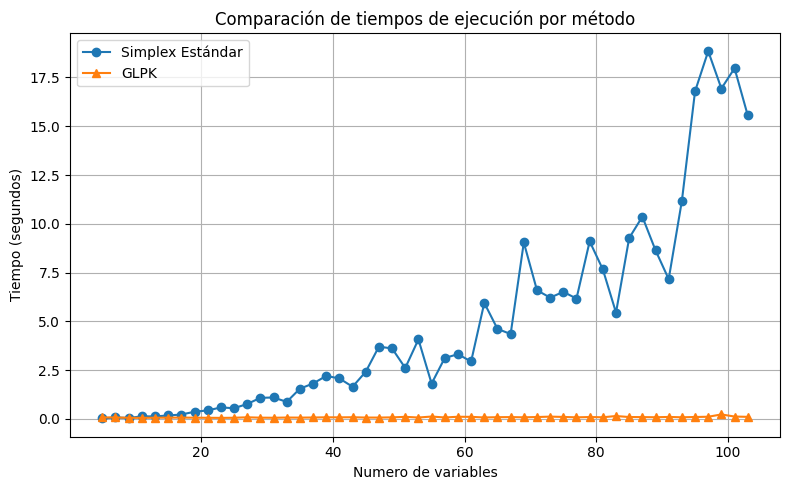

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Número de instancias (1 al número de casos)


plt.figure(figsize=(8,5))
plt.plot(numeroN, tiemposN, marker='o', label='Simplex Estándar')

plt.plot(numeroN, tiemposS, marker='^', label='GLPK')

plt.title("Comparación de tiempos de ejecución por método")
plt.xlabel("Numero de variables")
plt.ylabel("Tiempo (segundos)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Como nos podemos dar ceunta en los tiempos Simplex Estandar aumenta mucho el timpo cuando se aumentan las variables, encambio GLPK se mantiene constante con menos de 1 segundo.